In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob #to walk through folder structure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#2 -> Filter out INFO & WARNING messages 
# tf.autograph.set_verbosity(1)

In [2]:
def generate_data(batch_size,img_height,img_width,train_dir,val_dir):

    batch_size = batch_size #32
    img_height = img_height #128
    img_width = img_width #128


    #train_dir = 'data/skinlesion_500_split/train'
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    #val_dir = 'data/skinlesion_500_split/val'
    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    

    return train_ds,val_ds

## resnet50

In [3]:
train_ds,val_ds = generate_data(16,224,224,'data/skinlesion_500_split_8020/train','data/skinlesion_500_split_8020/val')

Found 2800 files belonging to 7 classes.
Metal device set to: Apple M2
Found 700 files belonging to 7 classes.


2022-12-18 20:30:19.539912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-18 20:30:19.540022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [26]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
rescale = tf.keras.layers.Rescaling(1.0/127.5,offset=-1) # rescaling to [-1,1]

base_model =tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet')

base_model.trainable =False #will later freeze and unfreeze accordingly
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [8]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-12-18 20:33:18.944044: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(16, 7, 7, 2048)


In [9]:
##classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [11]:
##prediction layer
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 7)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
len(model.trainable_variables)

2

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 14343     
                                                             

In [19]:
# model.compile(optimizer='adam', loss='categorical_crossentropy')
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

2022-12-18 20:47:53.509465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 6s 126ms/step - loss: 2.4118 - accuracy: 0.1457


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.41
initial accuracy: 0.15


In [22]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/10


2022-12-18 20:49:15.740159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 29s 159ms/step - loss: 2.0744 - accuracy: 0.1586 - val_loss: 1.9434 - val_accuracy: 0.1671
Epoch 2/10
175/175 [==============================] - 28s 159ms/step - loss: 1.9872 - accuracy: 0.1486 - val_loss: 1.9369 - val_accuracy: 0.1971
Epoch 3/10
175/175 [==============================] - 28s 159ms/step - loss: 1.9728 - accuracy: 0.1625 - val_loss: 1.9312 - val_accuracy: 0.1914
Epoch 4/10
175/175 [==============================] - 28s 159ms/step - loss: 1.9624 - accuracy: 0.1568 - val_loss: 1.9265 - val_accuracy: 0.2057
Epoch 5/10
175/175 [==============================] - 28s 158ms/step - loss: 1.9578 - accuracy: 0.1532 - val_loss: 1.9214 - val_accuracy: 0.1986
Epoch 6/10
175/175 [==============================] - 28s 158ms/step - loss: 1.9478 - accuracy: 0.1739 - val_loss: 1.9175 - val_accuracy: 0.1914
Epoch 7/10
175/175 [==============================] - 28s 158ms/step - loss: 1.9344 - accuracy: 0.1739 - val_loss: 1.9131 - val_accuracy: 0.2

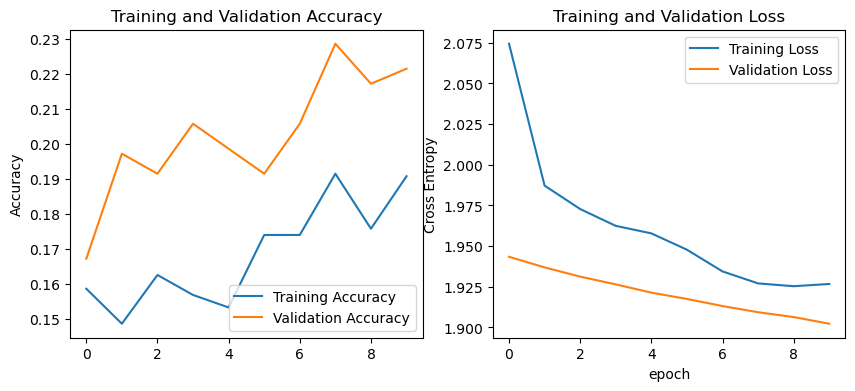

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [31]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 14343     
                                                             

In [32]:
len(model.trainable_variables)


32

In [33]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25


2022-12-18 20:57:47.061544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 1.9460 - accuracy: 0.1614

2022-12-18 20:58:14.707863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 34s 187ms/step - loss: 1.9460 - accuracy: 0.1614 - val_loss: 1.9175 - val_accuracy: 0.1943
Epoch 11/25
175/175 [==============================] - 32s 184ms/step - loss: 1.9165 - accuracy: 0.2029 - val_loss: 1.9198 - val_accuracy: 0.1743
Epoch 12/25
175/175 [==============================] - 32s 184ms/step - loss: 1.8857 - accuracy: 0.2118 - val_loss: 1.8575 - val_accuracy: 0.2171
Epoch 13/25
175/175 [==============================] - 33s 186ms/step - loss: 1.8314 - accuracy: 0.2379 - val_loss: 1.8243 - val_accuracy: 0.2443
Epoch 14/25
175/175 [==============================] - 32s 184ms/step - loss: 1.8035 - accuracy: 0.2446 - val_loss: 1.8358 - val_accuracy: 0.2457
Epoch 15/25
175/175 [==============================] - 32s 184ms/step - loss: 1.7738 - accuracy: 0.2746 - val_loss: 1.7030 - val_accuracy: 0.3071
Epoch 16/25
175/175 [==============================] - 33s 186ms/step - loss: 1.7355 - accuracy: 0.2846 - val_loss: 1.8052 - val_accurac

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

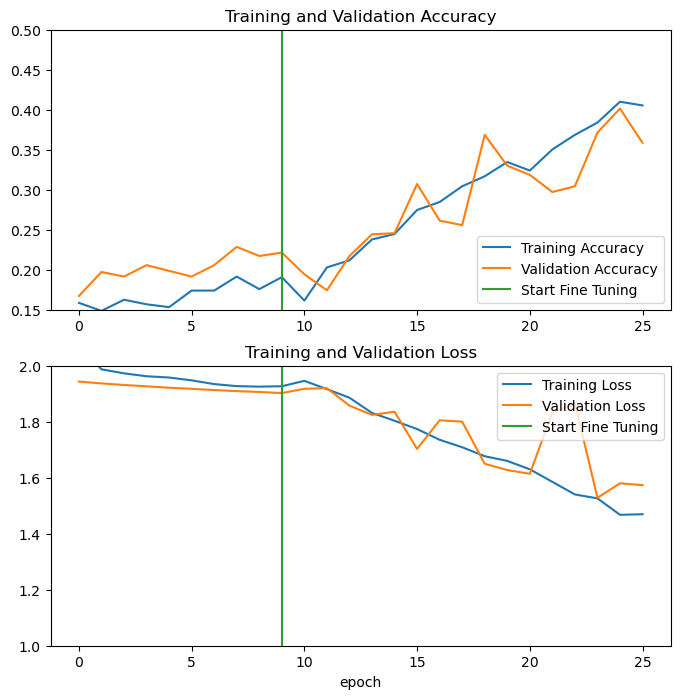

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.15, 0.5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([1, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### comments:
Though model improved after fine tuning, over all accuracy is pretty low

## Mobilenet - with input image size 32 x 32


In [37]:
train_ds,val_ds = generate_data(16,32,32,'data/skinlesion_500_split_8020/train','data/skinlesion_500_split_8020/val')

Found 2800 files belonging to 7 classes.
Found 700 files belonging to 7 classes.


In [38]:
rescale = tf.keras.layers.Rescaling(1.0/127.5,offset=-1) # rescaling to [-1,1]

base_model =keras.applications.mobilenet.MobileNet(
    include_top=False,
    input_shape=(32,32,3),
    weights='imagenet')

base_model.trainable =False #will later freeze and unfreeze accordingly
base_model.summary()

17225924/17225924 [==============================] - 3s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32) 

 ation)                                                          
                                                                 
 conv_dw_8_relu (ReLU)       (None, 2, 2, 512)         0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 2, 2, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 2, 2, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 2, 2, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 2, 2, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 2, 2, 512)        2048      
 ation)                                                          
          

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7)
inputs = tf.keras.Input(shape=(32, 32, 3))
x = rescale(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
print("Number of trainble variables :",len(model.trainable_variables))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 7175

In [42]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs =10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


2022-12-18 21:15:24.644692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


171/175 [============================>.] - ETA: 0s - loss: 1.9558 - accuracy: 0.1349

2022-12-18 21:15:28.024473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 5s 22ms/step - loss: 1.9558 - accuracy: 0.1346 - val_loss: 1.9498 - val_accuracy: 0.1300
Epoch 2/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9502 - accuracy: 0.1421 - val_loss: 1.9456 - val_accuracy: 0.1314
Epoch 3/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9448 - accuracy: 0.1439 - val_loss: 1.9417 - val_accuracy: 0.1357
Epoch 4/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9406 - accuracy: 0.1496 - val_loss: 1.9382 - val_accuracy: 0.1371
Epoch 5/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9374 - accuracy: 0.1486 - val_loss: 1.9353 - val_accuracy: 0.1529
Epoch 6/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9357 - accuracy: 0.1593 - val_loss: 1.9325 - val_accuracy: 0.1571
Epoch 7/10
175/175 [==============================] - 4s 20ms/step - loss: 1.9332 - accuracy: 0.1500 - val_loss: 1.9299 - val_accuracy: 0.1700
Epoch 8/10

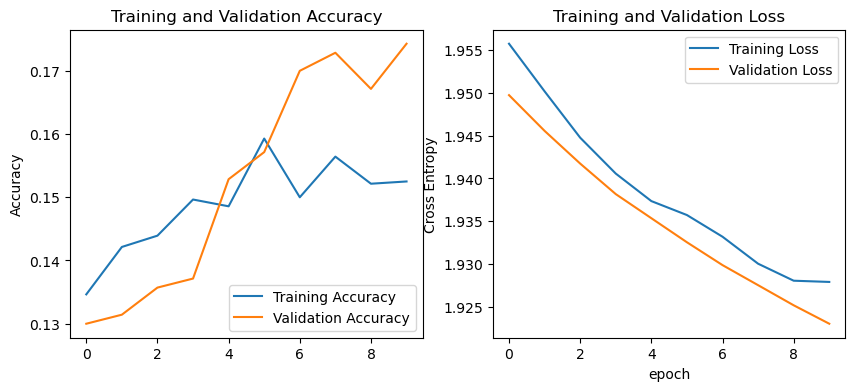

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
##fine tuning 
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  86


In [45]:
# Fine-tune from this layer onwards
fine_tune_at = 50
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [46]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
print("Number of trainble variables :",len(model.trainable_variables))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 7175

In [47]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/35


2022-12-18 21:18:50.047739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


172/175 [============================>.] - ETA: 0s - loss: 1.7949 - accuracy: 0.2598

2022-12-18 21:18:55.169326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 7s 31ms/step - loss: 1.7945 - accuracy: 0.2607 - val_loss: 1.6643 - val_accuracy: 0.3629
Epoch 11/35
175/175 [==============================] - 5s 27ms/step - loss: 1.6896 - accuracy: 0.3211 - val_loss: 1.5701 - val_accuracy: 0.4086
Epoch 12/35
175/175 [==============================] - 5s 28ms/step - loss: 1.5799 - accuracy: 0.3804 - val_loss: 1.4519 - val_accuracy: 0.4314
Epoch 13/35
175/175 [==============================] - 5s 28ms/step - loss: 1.5008 - accuracy: 0.4236 - val_loss: 1.4024 - val_accuracy: 0.4771
Epoch 14/35
175/175 [==============================] - 5s 28ms/step - loss: 1.4535 - accuracy: 0.4304 - val_loss: 1.4517 - val_accuracy: 0.3929
Epoch 15/35
175/175 [==============================] - 5s 29ms/step - loss: 1.3589 - accuracy: 0.4754 - val_loss: 1.3059 - val_accuracy: 0.5271
Epoch 16/35
175/175 [==============================] - 5s 28ms/step - loss: 1.3054 - accuracy: 0.4961 - val_loss: 1.2132 - val_accuracy: 0.5500
Epoc

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [50]:
history_fine_2 = model.fit(train_ds,
                         epochs=55,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=val_ds)

Epoch 35/55
175/175 [==============================] - 5s 28ms/step - loss: 0.6085 - accuracy: 0.7875 - val_loss: 0.8643 - val_accuracy: 0.6957
Epoch 36/55
175/175 [==============================] - 5s 28ms/step - loss: 0.5843 - accuracy: 0.7886 - val_loss: 0.8980 - val_accuracy: 0.6857
Epoch 37/55
175/175 [==============================] - 5s 28ms/step - loss: 0.5568 - accuracy: 0.8036 - val_loss: 0.9257 - val_accuracy: 0.6729
Epoch 38/55
175/175 [==============================] - 5s 28ms/step - loss: 0.5607 - accuracy: 0.8143 - val_loss: 0.9262 - val_accuracy: 0.6571
Epoch 39/55
175/175 [==============================] - 5s 28ms/step - loss: 0.5616 - accuracy: 0.8104 - val_loss: 0.8904 - val_accuracy: 0.6800
Epoch 40/55
175/175 [==============================] - 5s 27ms/step - loss: 0.5345 - accuracy: 0.8086 - val_loss: 1.0069 - val_accuracy: 0.6657
Epoch 41/55
175/175 [==============================] - 5s 27ms/step - loss: 0.5272 - accuracy: 0.8200 - val_loss: 0.9177 - val_accuracy:

In [51]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [54]:
history_fine_3 = model.fit(train_ds,
                         epochs=75,
                         initial_epoch=history_fine_2.epoch[-1],
                         validation_data=val_ds)

Epoch 55/75
175/175 [==============================] - 5s 28ms/step - loss: 0.3506 - accuracy: 0.8811 - val_loss: 1.1192 - val_accuracy: 0.6800
Epoch 56/75
175/175 [==============================] - 5s 29ms/step - loss: 0.2506 - accuracy: 0.9196 - val_loss: 1.0307 - val_accuracy: 0.7057
Epoch 57/75
175/175 [==============================] - 5s 27ms/step - loss: 0.2677 - accuracy: 0.9200 - val_loss: 1.2565 - val_accuracy: 0.6500
Epoch 58/75
175/175 [==============================] - 5s 28ms/step - loss: 0.2719 - accuracy: 0.9136 - val_loss: 1.1173 - val_accuracy: 0.6786
Epoch 59/75
175/175 [==============================] - 5s 28ms/step - loss: 0.2291 - accuracy: 0.9304 - val_loss: 1.0072 - val_accuracy: 0.6986
Epoch 60/75
175/175 [==============================] - 5s 29ms/step - loss: 0.2496 - accuracy: 0.9236 - val_loss: 1.0929 - val_accuracy: 0.6671
Epoch 61/75
175/175 [==============================] - 5s 27ms/step - loss: 0.1936 - accuracy: 0.9429 - val_loss: 1.0872 - val_accuracy:

In [55]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

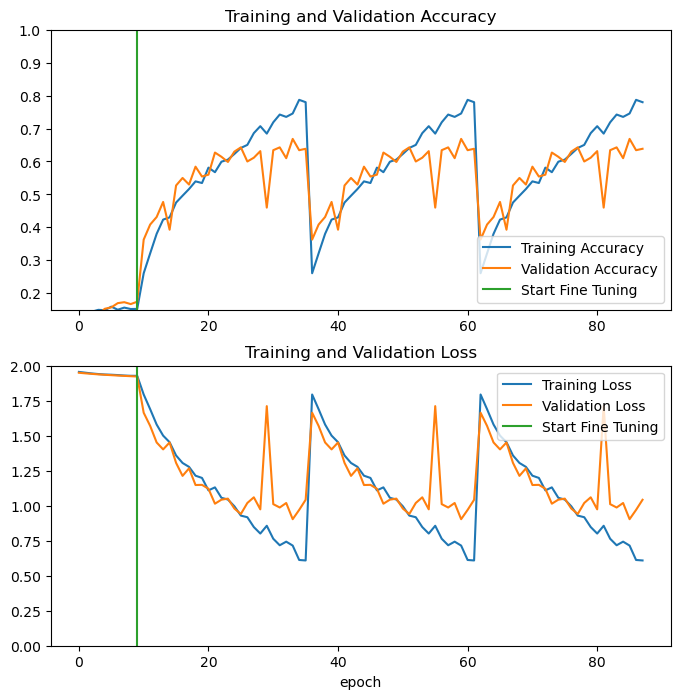

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.15, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [57]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

44/44 [==============================] - 1s 16ms/step - loss: 1.1770 - accuracy: 0.6900
Test accuracy : 0.6899999976158142


## InceptionResNetV2

In [64]:
rescale = tf.keras.layers.Rescaling(1.0/127.5,offset=-1) # rescaling to [-1,1]
base_model =tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    input_shape=(75,75,3),
    weights='imagenet')

base_model.trainable =False #will later freeze and unfreeze accordingly
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7)
inputs = tf.keras.Input(shape=(75, 75, 3))
x= rescale(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
print("Number of trainble variables :",len(model.trainable_variables))

219055592/219055592 [==============================] - 16s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 75, 75, 3)         0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_7   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0         
                                                         

In [65]:
train_ds,val_ds = generate_data(16,75,75,'data/skinlesion_500_split_8020/train','data/skinlesion_500_split_8020/val')

Found 2800 files belonging to 7 classes.
Found 700 files belonging to 7 classes.


In [66]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs =10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


2022-12-18 21:46:53.485637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 2.3024 - accuracy: 0.1936

2022-12-18 21:47:07.211549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 22s 93ms/step - loss: 2.3024 - accuracy: 0.1936 - val_loss: 1.8562 - val_accuracy: 0.2914
Epoch 2/10
175/175 [==============================] - 12s 70ms/step - loss: 1.9255 - accuracy: 0.2711 - val_loss: 1.6706 - val_accuracy: 0.3686
Epoch 3/10
175/175 [==============================] - 12s 70ms/step - loss: 1.7015 - accuracy: 0.3561 - val_loss: 1.5689 - val_accuracy: 0.3957
Epoch 4/10
175/175 [==============================] - 12s 69ms/step - loss: 1.6122 - accuracy: 0.4025 - val_loss: 1.5014 - val_accuracy: 0.4386
Epoch 5/10
175/175 [==============================] - 12s 71ms/step - loss: 1.5359 - accuracy: 0.4346 - val_loss: 1.4554 - val_accuracy: 0.4571
Epoch 6/10
175/175 [==============================] - 12s 69ms/step - loss: 1.4582 - accuracy: 0.4739 - val_loss: 1.4247 - val_accuracy: 0.4857
Epoch 7/10
175/175 [==============================] - 12s 70ms/step - loss: 1.4172 - accuracy: 0.4829 - val_loss: 1.3907 - val_accuracy: 0.4914
Epo

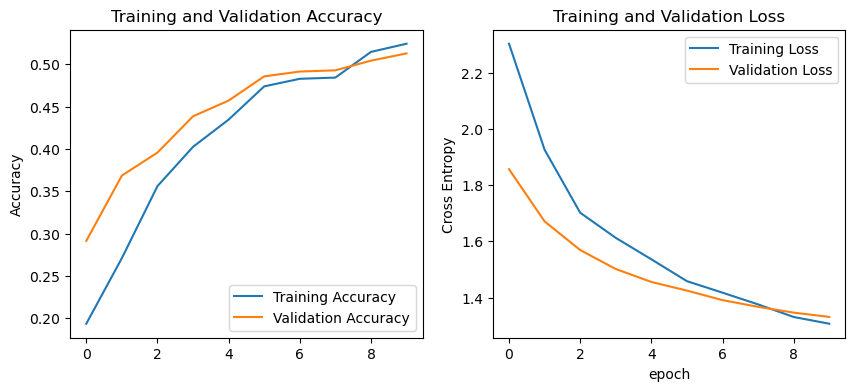

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [79]:
##fine tuning 
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
num_layers = len(base_model.layers)

# Fine-tune from this layer onwards
fine_tune_at = round(0.7 * num_layers) ## top 30%
print("fine tuning from:",fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
print("Number of trainble variables :",len(model.trainable_variables))

Number of layers in the base model:  780
fine tuning from: 546
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 75, 75, 3)         0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_7   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0         
                                                              

In [80]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/35


2022-12-18 21:53:02.045170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 1.1843 - accuracy: 0.5582

2022-12-18 21:53:27.806830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 37s 160ms/step - loss: 1.1843 - accuracy: 0.5582 - val_loss: 0.9113 - val_accuracy: 0.6686
Epoch 11/35
175/175 [==============================] - 21s 119ms/step - loss: 0.6587 - accuracy: 0.7579 - val_loss: 0.7778 - val_accuracy: 0.7000
Epoch 12/35
175/175 [==============================] - 21s 118ms/step - loss: 0.3521 - accuracy: 0.8793 - val_loss: 0.8537 - val_accuracy: 0.7014
Epoch 13/35
175/175 [==============================] - 21s 118ms/step - loss: 0.1621 - accuracy: 0.9411 - val_loss: 0.8346 - val_accuracy: 0.7329
Epoch 14/35
175/175 [==============================] - 21s 117ms/step - loss: 0.0857 - accuracy: 0.9743 - val_loss: 0.9830 - val_accuracy: 0.7229
Epoch 15/35
175/175 [==============================] - 21s 117ms/step - loss: 0.0857 - accuracy: 0.9771 - val_loss: 1.1120 - val_accuracy: 0.7400
Epoch 16/35
175/175 [==============================] - 21s 118ms/step - loss: 0.0728 - accuracy: 0.9800 - val_loss: 0.9967 - val_accurac

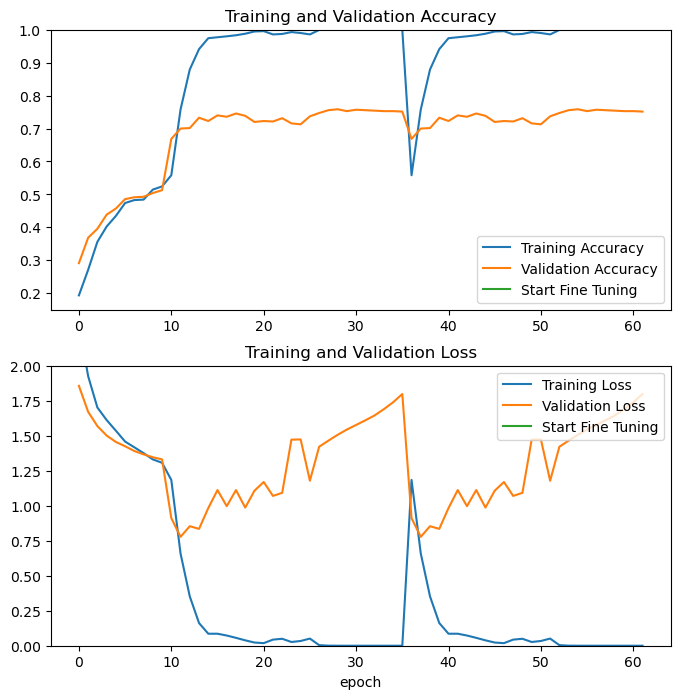

In [82]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.15, 1])
plt.plot([initial_epochs-1,initial_epochs-1], label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1], label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [83]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

44/44 [==============================] - 3s 53ms/step - loss: 1.7977 - accuracy: 0.7514
Test accuracy : 0.7514285445213318
